# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# df.drop('in_btc', axis=1, inplace=True)
# df.drop('out_btc', axis=1, inplace=True)
# df.drop('total_btc', axis=1, inplace=True)
# df.drop('mean_in_btc', axis=1, inplace=True)
# df.drop('mean_out_btc', axis=1, inplace=True)


df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [7]:
del df #free memory
gc.collect()

14

# Split

In [8]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [9]:
pd.value_counts(original_ytrain)

0    24198425
1          82
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

In [11]:
del scaled_df #free memory
gc.collect()

17

# Get Training Sample

In [12]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Get Test Sample

In [13]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Oversample Training Data

In [14]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

# Evaluation Metrics

In [15]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

# Fit Model

In [16]:
from auto_encoder import AutoEncoder

epochs = 100
random_state = 42
batch_size = 256
outliers_fraction = 0.08169

print('Training Parameters:\n====================\n')
print('Epochs: '+ str(epochs))
print('Outliers Fraction: '+ str(outliers_fraction))

# params: {'hidden_activation': 'tanh', 'hidden_neurons1': 3.00862662842245, 'hidden_neurons2': 5.52633745019447, 'outliers_fraction': 0.08169065288006816, 'output_activation': 'sigmoid'}

mpath = '/Users/omershafiq/Dropbox/Thesis/Analysis-Code/Analysis-2019/Notebooks/Final/Unsupervised/Models/Autoencoder/autoencoder_model.h5'
lpath = '/Users/omershafiq/Dropbox/Thesis/Analysis-Code/Analysis-2019/Notebooks/Final/Unsupervised/Models/Autoencoder/logs'

def fit_model(X_train):
    clf = AutoEncoder(hidden_neurons=[6, 4, 4, 6], 
                      hidden_activation='tanh', 
                      output_activation='sigmoid', 
                      loss='mean_squared_logarithmic_error', 
                      optimizer='adam',
                      epochs=epochs, 
                      batch_size=batch_size, 
                      dropout_rate=0.1, 
                      l2_regularizer=0.000001, 
                      validation_size=0.20, 
                      preprocessing=False, 
                      verbose=1, 
                      random_state=random_state, 
                      contamination=outliers_fraction)
    clf.fit(X_train, model_path=mpath, log_path=lpath)
    return clf

Using TensorFlow backend.


Training Parameters:

Epochs: 100
Outliers Fraction: 0.08169


#  Modeling

In [17]:
training_evaluations = {}
test_evaluations = {}
model = {}

i=0
X_train, y_train = oversample_minority_class(original_Xtrain, original_ytrain, outliers_fraction)

#Modeling
start = time.time()
clf = fit_model(X_train)
end = time.time()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 48        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 28        
__________

20940155/20940155 [==============================] - 235s 11us/step - loss: 0.0595 - f1: 0.8934 - val_loss: 0.0568 - val_f1: 0.9032
Epoch 98/100
20940155/20940155 [==============================] - 234s 11us/step - loss: 0.0595 - f1: 0.8929 - val_loss: 0.0565 - val_f1: 0.9014
Epoch 99/100
20940155/20940155 [==============================] - 234s 11us/step - loss: 0.0594 - f1: 0.8936 - val_loss: 0.0567 - val_f1: 0.9035
Epoch 100/100
20940155/20940155 [==============================] - 237s 11us/step - loss: 0.0595 - f1: 0.8933 - val_loss: 0.0594 - val_f1: 0.8782


In [18]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

training_time = round(end - start, 4)
model[i+1] = clf
training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)

print("Model Trained!")

test_start = time.time()
y_test_pred = clf.predict(original_Xtest)
y_test_scores = clf.decision_function(original_Xtest)
test_end = time.time()
testing_time = round(test_end - test_start, 4)
test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

print("Evaluation completed!    Training Time: "+str(training_time)+" seconds")

Model Trained!
Evaluation completed!    Training Time: 25075.109 seconds


# Tabular Evaluation

In [19]:
training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(training_evaluations.keys()):
    training_eval_df = training_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : training_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : training_evaluations[it]['macro_precision'],
                             'Macro-Recall' : training_evaluations[it]['macro_recall'],
                             'Macro-F1' : training_evaluations[it]['macro_f1'],
                             'Macro-ROC' : training_evaluations[it]['macro_roc'],
                             'Precision' : training_evaluations[it]['precision'],
                             'Recall' : training_evaluations[it]['recall'],
                             'F1' : training_evaluations[it]['f1'],
                             'ROC' : training_evaluations[it]['roc'],
                             'Time' : training_evaluations[it]['time']                                              
                            }, ignore_index=True)
    
for it in list(test_evaluations.keys()):
    test_eval_df = test_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : test_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : test_evaluations[it]['macro_precision'],
                             'Macro-Recall' : test_evaluations[it]['macro_recall'],
                             'Macro-F1' : test_evaluations[it]['macro_f1'],
                             'Macro-ROC' : test_evaluations[it]['macro_roc'],
                             'Precision' : test_evaluations[it]['precision'],
                             'Recall' : test_evaluations[it]['recall'],
                             'F1' : test_evaluations[it]['f1'],
                             'ROC' : test_evaluations[it]['roc'],
                             'Time' : test_evaluations[it]['time']                                              
                            }, ignore_index=True)

In [20]:
training_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.920231,0.733119,0.716962,0.733119,0.724655,0.870147,0.473996,0.512718,0.492597,0.870147,25075.109


In [21]:
training_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.920231,0.733119,0.716962,0.733119,0.724655,0.870147,0.473996,0.512718,0.492597,0.870147,25075.109


In [22]:
test_eval_df.sort_values('Macro-F1', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.953487,0.803667,0.500029,0.803667,0.488155,0.907563,0.00006,0.653846,0.000121,0.907563,177.6881


In [23]:
test_eval_df.sort_values('ROC', ascending=False)

,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.953487,0.803667,0.500029,0.803667,0.488155,0.907563,0.00006,0.653846,0.000121,0.907563,177.6881


# Visualization

### Metrics

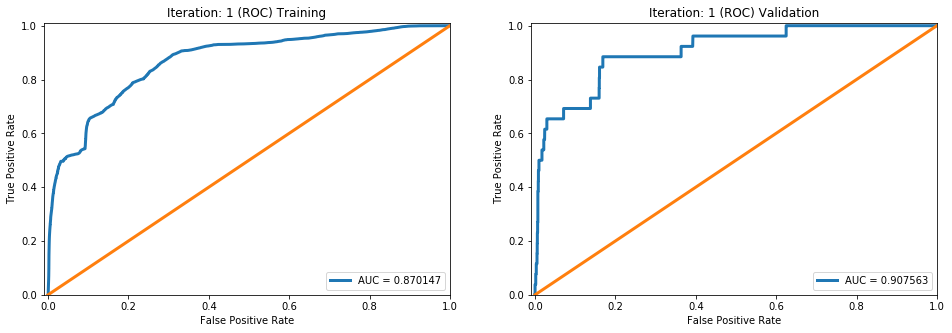

<Figure size 432x288 with 0 Axes>

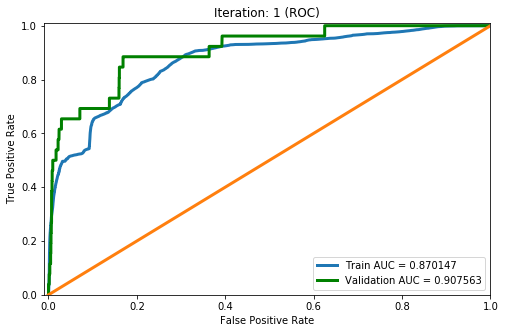

In [24]:
it = 1
false_pos_rate = training_evaluations[it]['false_pos_rate']
true_pos_rate = training_evaluations[it]['true_pos_rate']
roc_auc = auc(false_pos_rate, true_pos_rate)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
ax1.plot([0,1],[0,1], linewidth=3)

ax1.set_xlim([-0.01, 1])
ax1.set_ylim([0, 1.01])
ax1.legend(loc='lower right')
ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')


test_false_pos_rate = test_evaluations[it]['false_pos_rate']
test_true_pos_rate = test_evaluations[it]['true_pos_rate']
test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
ax2.plot([0,1],[0,1], linewidth=3)

ax2.set_xlim([-0.01, 1])
ax2.set_ylim([0, 1.01])
ax2.legend(loc='lower right')
ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

plt.figure(2)
false_pos_rate = training_evaluations[it]['false_pos_rate']
true_pos_rate = training_evaluations[it]['true_pos_rate']
roc_auc = auc(false_pos_rate, true_pos_rate)

test_false_pos_rate = test_evaluations[it]['false_pos_rate']
test_true_pos_rate = test_evaluations[it]['true_pos_rate']
test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

plt.figure(figsize=(8, 5))
plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
plt.plot([0,1],[0,1], linewidth=3)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])

plt.legend(loc='lower right')
plt.title('Iteration: '+ str(it) +' (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 0, 'Threshold')

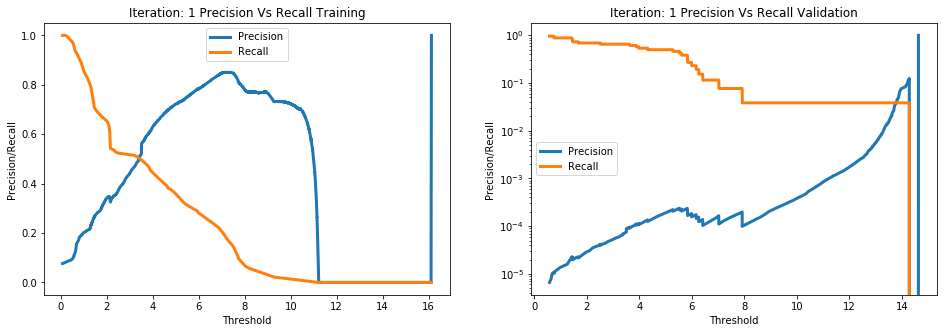

In [25]:
precision_rt = training_evaluations[it]['precision_rt']
recall_rt = training_evaluations[it]['recall_rt']
threshold_rate = training_evaluations[it]['threshold_rt']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax1.set_yscale('log')
ax1.legend()
ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
ax1.set_ylabel('Precision/Recall')
ax1.set_xlabel('Threshold')


precision_rt = test_evaluations[it]['precision_rt']
recall_rt = test_evaluations[it]['recall_rt']
threshold_rate = test_evaluations[it]['threshold_rt']
ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
ax2.legend()
ax2.set_yscale('log')
ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
ax2.set_ylabel('Precision/Recall')
ax2.set_xlabel('Threshold')

# Reconstruction

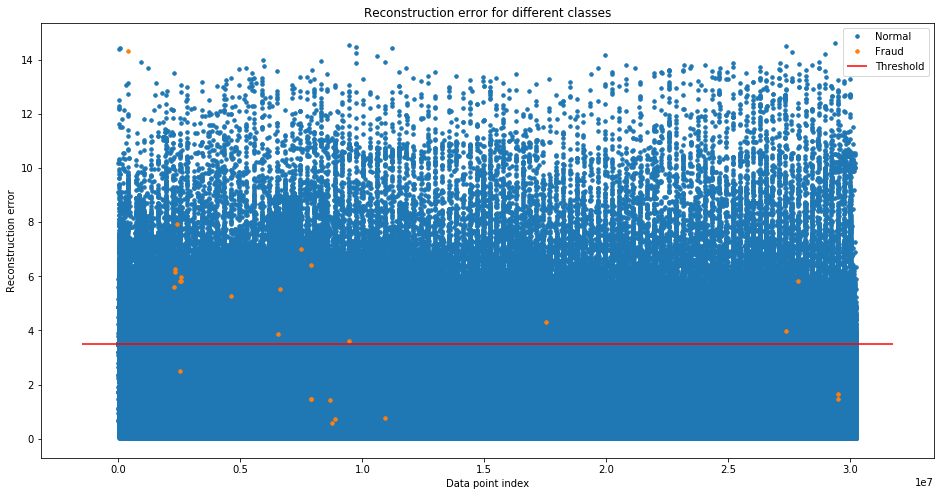

In [41]:
test_threshold = 3.5

test_error_df = pd.DataFrame({'Reconstruction_error': y_test_scores, 'True_class': original_ytest})
train_error_df = pd.DataFrame({'Reconstruction_error': y_train_scores, 'True_class': y_train})

groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(16, 8))

for name, group in groups:
    ax.plot(list(group.index), group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
    
    
ax.hlines(test_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Confusion Matrix

In [42]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [43]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [44]:
test_pred_y = [1 if e > test_threshold else 0 for e in test_error_df.Reconstruction_error.values]
train_pred_y = [1 if e > test_threshold else 0 for e in train_error_df.Reconstruction_error.values]
cnf_mtx_test = confusion_matrix(test_error_df.True_class, test_pred_y)
cnf_mtx_train = confusion_matrix(train_error_df.True_class, train_pred_y)

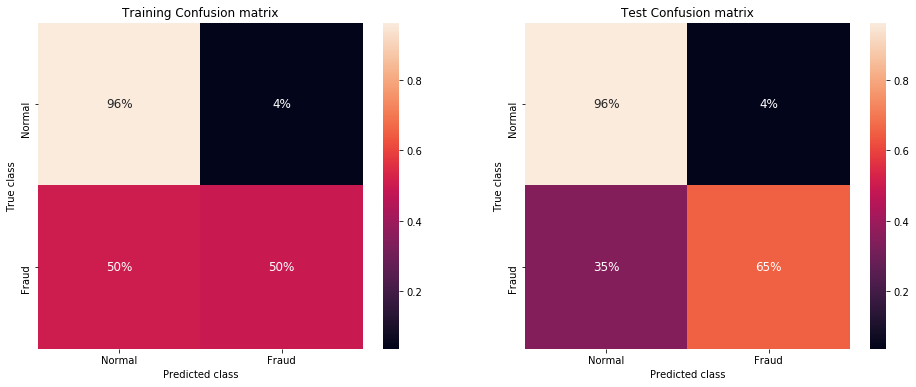

In [45]:
conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, 1)

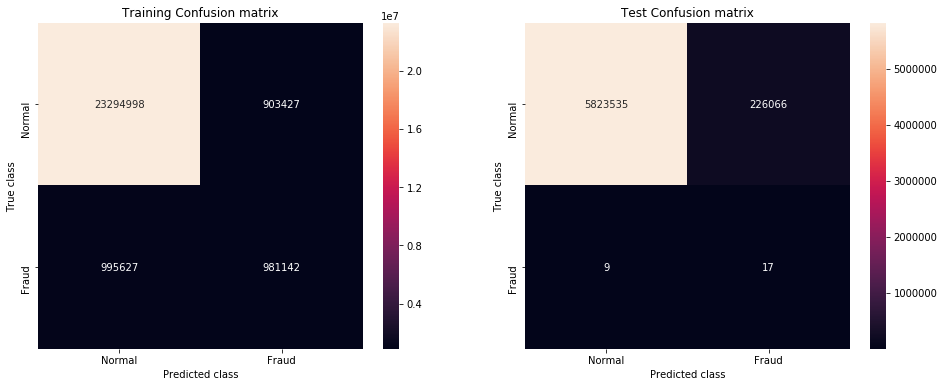

In [46]:
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, 1)

# Parameter Tuning

In [ ]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

space={
'hidden_neurons1': hp.uniform('hidden_neurons1', 6, 3),
'hidden_neurons2': hp.uniform('hidden_neurons2', 6, 2),
'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.27),
'hidden_activation': hp.choice('hidden_activation', ['tanh', 'softmax', 'sigmoid']),
'output_activation': hp.choice('output_activation', ['tanh', 'softmax', 'sigmoid']),
}

random_state = 42
# training_sample_size = int(len(original_ytrain) / 5)
# sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
# print('Training With:')
# print(pd.value_counts(sample_ytrain))


def hyper_parm_opt(space):
    start = time.time()
    hidden_neurons1 = round(space['hidden_neurons1'])
    hidden_neurons2 = round(space['hidden_neurons2'])
    hidden_activation = str(space['hidden_activation'])
    output_activation = str(space['output_activation'])
    outliers_fraction = space['outliers_fraction']
    
    neurons = []
    
    if hidden_neurons1 > hidden_neurons2:
        neurons = [hidden_neurons1, hidden_neurons2, hidden_neurons2, hidden_neurons1]
    elif hidden_neurons1 < hidden_neurons2:
        neurons = [hidden_neurons2, hidden_neurons1, hidden_neurons1, hidden_neurons2]
    else:
        neurons = [hidden_neurons1+1, hidden_neurons2, hidden_neurons2, hidden_neurons1+1]
        
    X_train, y_train = oversample_minority_class(original_Xtrain, original_ytrain, outliers_fraction)
#     X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = AutoEncoder(hidden_neurons=neurons, 
                      hidden_activation=hidden_activation, 
                      output_activation=output_activation, 
                      loss='mean_squared_logarithmic_error', 
                      optimizer='adam', 
                      epochs=1, 
                      batch_size=512, 
                      dropout_rate=0.1, 
                      l2_regularizer=0.00001, 
                      validation_size=0.20, 
                      preprocessing=False, 
                      verbose=2, 
                      random_state=random_state, 
                      contamination=outliers_fraction)
    print('=======================================\n')
    print('params: '+ str(space))
    print('\n')
    clf.fit(X_train)
    print('\n')
#     y_train_pred = clf.labels_
#     score = f1_score(y_train, y_train_pred, average="macro")
    val = min(clf.history_['val_loss']) #1 - score
    end = time.time()
    print('time: ' + str(round(end - start, 4)) + ' seconds')
    print('val: ' + str(val))
    print('=======================================\n')
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=50, trials=trials)


print('\n\n\nbest: {}'.format(best))